In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
torch.manual_seed(1)
x = torch.unsqueeze(torch.linspace(-1, 1, 300), dim=1)  
pi_value = torch.tensor(5 * np.pi, dtype=torch.float32)  
y = torch.sin(pi_value * x) / (pi_value * x) 
y[x == 0] = 1 
x, y = x.float(), y.float()


In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 4),
            nn.LeakyReLU(),
            nn.Linear(4, 9),
            nn.LeakyReLU(),
            nn.Linear(9, 12),
            nn.LeakyReLU(),
            nn.Linear(12, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 4),
            nn.LeakyReLU()
        )
        self.predict = nn.Linear(4, 1)

    def forward(self, x):
        x = self.layers(x)  
        x = self.predict(x)  
        return x


In [6]:
model = Model()
total_params = sum(p.numel() for p in model.parameters())
print('Total no of parameters ', total_params)

Total no of parameters  572


In [8]:
def train_model(model, x, y):
    epoch_size = 4000
    loss_arr = []
    epoch_arr = []
    grad_arr = []
    converged = False
    min_grad = 0
    loss_val = 0
    minimal_ratio = 0.0

    for epoch in range(epoch_size):
        if converged:
            return epoch_arr, loss_arr, y_prediction, grad_arr

        # Forward pass and loss computation
        y_prediction = model(x)
        lossm_val = 0.001  # Initialize with a small value
        loss = loss_func(y_prediction, y)
        optimizer.zero_grad()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        epoch_arr.append(epoch)
        loss_arr.append(loss.detach().numpy())

        # Gradient calculation
        grad_all = sum((p.grad.cpu().data.numpy()**2).sum() for p in model.parameters() if p.grad is not None)
        grad_norm = grad_all ** 0.5
        grad_arr.append(grad_norm)

        total_params = sum(p.numel() for p in model.parameters())
        if grad_norm < 0.001 or epoch == epoch_size - 1:
            print('The gradient norm has reached a minimum value.')
            predicted_y = model(x)
            lossm = loss_func(predicted_y, y)

            # Create Hessian matrix H
            H = torch.zeros((total_params, total_params))
            gradient = torch.autograd.grad(lossm, list(model.parameters()), create_graph=True)
            flat_gradient = torch.cat([g.flatten() for g in gradient])  # Flatten the gradients

            for i in range(total_params):
                result = torch.autograd.grad(flat_gradient[i], list(model.parameters()), retain_graph=True)
                H[i] = torch.cat([r.flatten() for r in result])  # Flatten each result into H

            # Compute eigenvalues of the Hessian matrix
            H_eig = torch.linalg.eigvalsh(H, UPLO='U')  # Eigenvalues of H (symmetric)
            
            # Count positive eigenvalues
            positive_count = sum(1 for e in H_eig.tolist() if e > 0)
            minimal_ratio = positive_count / H.shape[0]

            # Output diagnostic information
            print('Minimal Ratio:', minimal_ratio)
            print('Final Loss:', lossm.data.detach().numpy())
            print('Final Epoch:', epoch)
            
            lossm_val = lossm.data.detach().numpy()
            break

    return lossm_val, minimal_ratio


In [9]:
loss_arr = []
min_ratio_arr = []

for index in range(100):
    print(f"Training model {index}") 
    model = Model()
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_value, min_ratio = train_model(model, x, y)
    loss_arr += [loss_value]  
    min_ratio_arr += [min_ratio]  


Training model 0
The gradient norm has reached a minimum value.
Minimal Ratio: 0.5402097902097902
Final Loss: 0.0020719476
Final Epoch: 1183
Training model 1
The gradient norm has reached a minimum value.
Minimal Ratio: 0.5017482517482518
Final Loss: 0.086902484
Final Epoch: 24
Training model 2
The gradient norm has reached a minimum value.
Minimal Ratio: 0.5297202797202797
Final Loss: 0.0027165052
Final Epoch: 1123
Training model 3
The gradient norm has reached a minimum value.
Minimal Ratio: 0.4982517482517482
Final Loss: 0.08689961
Final Epoch: 151
Training model 4
The gradient norm has reached a minimum value.
Minimal Ratio: 0.5017482517482518
Final Loss: 0.08686993
Final Epoch: 98
Training model 5
The gradient norm has reached a minimum value.
Minimal Ratio: 0.5384615384615384
Final Loss: 0.0023828351
Final Epoch: 598
Training model 6
The gradient norm has reached a minimum value.
Minimal Ratio: 0.5437062937062938
Final Loss: 0.0002924069
Final Epoch: 3129
Training model 7
The gra

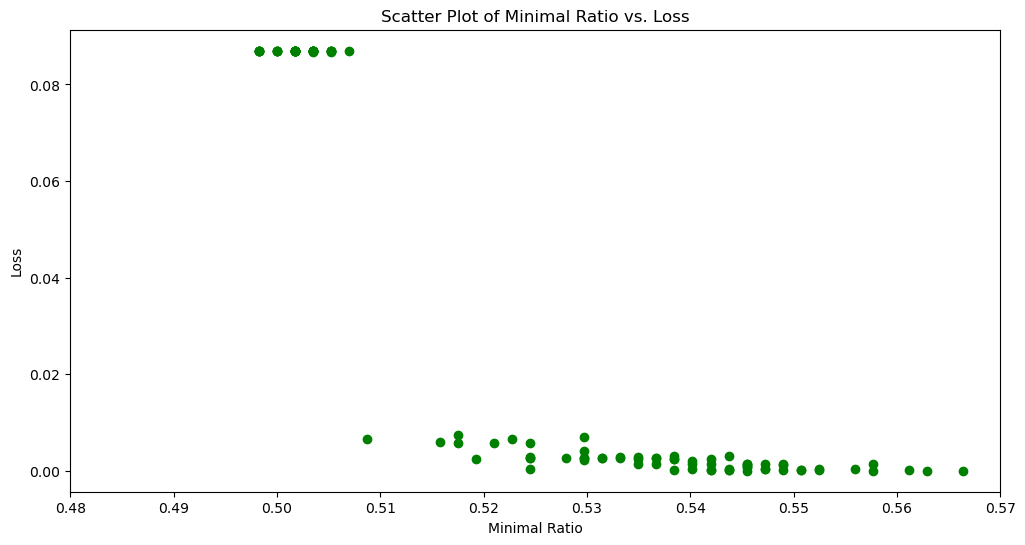

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x=min_ratio_arr, y=loss_arr, c="green")
ax.set_xlabel("Minimal Ratio")
ax.set_ylabel("Loss")
ax.set_title("Scatter Plot of Minimal Ratio vs. Loss")
ax.set_xlim([0.48, 0.57])
plt.show()
